In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [112]:
img1 = cv2.cvtColor(cv2.imread("1.jpeg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("2.jpeg"), cv2.COLOR_BGR2RGB)
img1.shape, img2.shape

((1280, 960, 3), (1280, 960, 3))

## Core

In [282]:
def detect_sift_points_and_descriptors(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(grayscale, None)
    return np.array([kp.pt for kp in keypoints]), descriptors

def snn_matching(query_descriptors, train_descriptors):
    matcher = cv2.BFMatcher_create(cv2.NORM_L2, False)
    all_matches = matcher.knnMatch(query_descriptors, train_descriptors, 2)
    return [m1 for m1, m2 in all_matches if m1.distance < 0.8 * m2.distance]

def find_matches(points1, descriptors1,
                 points2, descriptors2):
    matches = snn_matching(query_descriptors=descriptors1, train_descriptors=descriptors2)
    return np.array([points1[m.queryIdx] for m in matches]), np.array([points2[m.trainIdx] for m in matches])

def find_homography(points1, points2):
    MIN_MATCHES, MIN_INLIERS = 100, 30
    if len(points1) < MIN_MATCHES:
        return False
    hmat, inliers_mask = cv2.findHomography(points2, points1, cv2.RANSAC)
    return hmat if np.sum(inliers_mask) >= MIN_INLIERS else None

def find_all_homography(images):
    first_img = images[0]
    points1, descriptors1 = detect_sift_points_and_descriptors(first_img)
    homography_matrices = [(np.eye(3), first_img)] # for source image identity transform
    for img in images[1:]:
        points, descriptors = detect_sift_points_and_descriptors(img)
        matched_points = find_matches(points1, descriptors1, points, descriptors)
        hmat = find_homography(matched_points[0], matched_points[1])
        if hmat is not None:
            homography_matrices.append((hmat, img))
    
    return homography_matrices

## Draw matched points

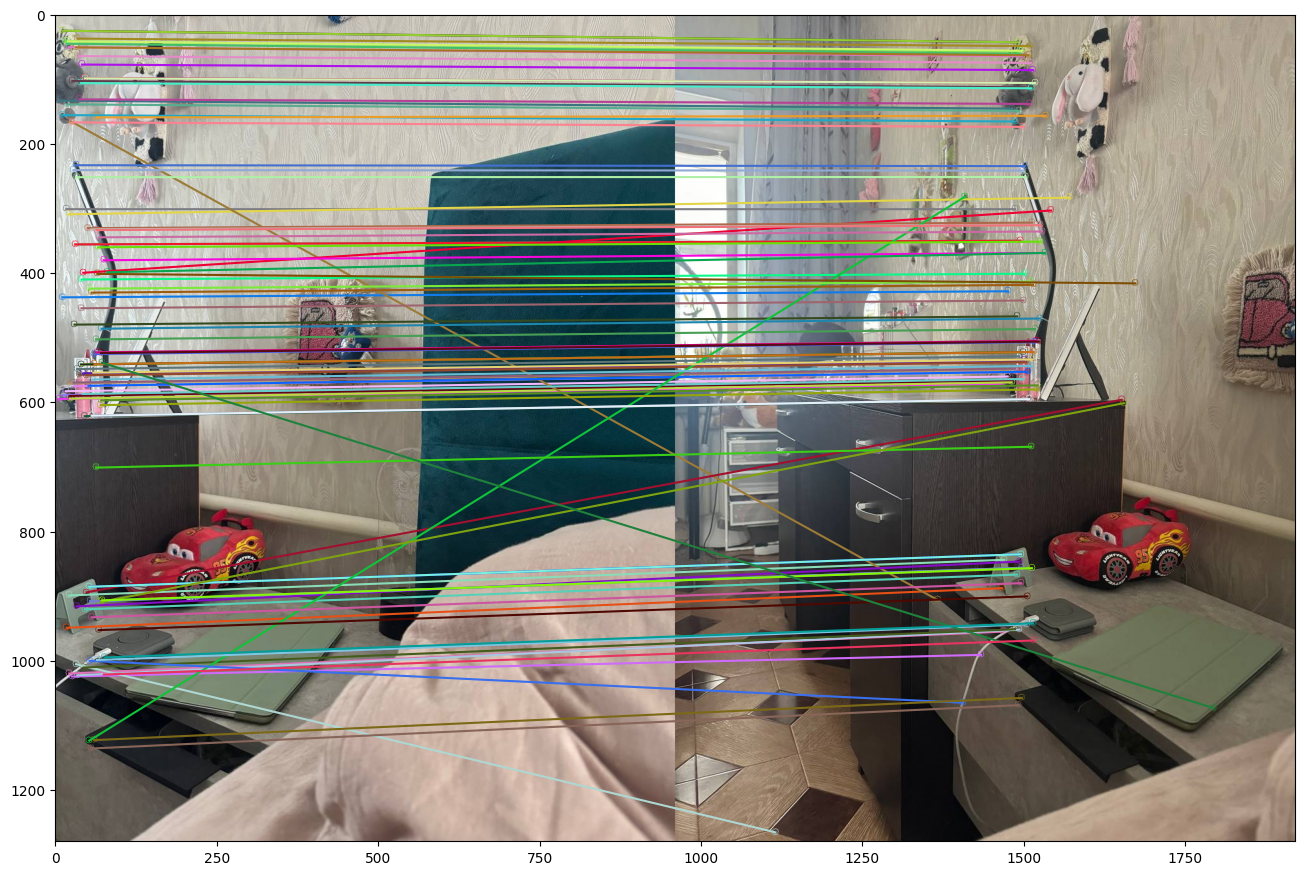

In [283]:
points1, descriptors1 = detect_sift_points_and_descriptors(img1)
points, descriptors = detect_sift_points_and_descriptors(img2)

matches = find_matches(points1, descriptors1, points, descriptors)
_im1, _im2 = img1.copy(), img2.copy()
lines = []
for point0, point1 in zip(matches[0][:100], matches[1][:100]):
    color = np.random.randint(0, 255, (3,)).tolist()
    _im1 = cv2.circle(_im1, point0.astype(int), radius=5, color=color, thickness=1)
    _im2 = cv2.circle(_im2, point1.astype(int), radius=5, color=color, thickness=1)
    lines.append(plt.Line2D((point0[0], point1[0] + _im2.shape[1]), (point0[1], point1[1]), color=np.array(color).astype(float) / 255))

stitched_image = np.empty((_im1.shape[0], _im1.shape[1] * 2, 3))
stitched_image[:, :_im1.shape[1]] = _im1
stitched_image[:, _im1.shape[1]:] = _im2
plt.figure(figsize=(16, 20))
plt.imshow(stitched_image.astype(int))
for line in lines:
    plt.gca().add_line(line)

## Compute panorama resulting size

In [376]:
# Get panorama box
def get_occluding_bbox(source_image_shape, hmat):
    h, w = source_image_shape[:2]
    source_box = np.float32([
        # x, y, z
        [0, 0, 1],
        [0, h, 1],
        [w, h, 1],
        [w, 0, 1]
    ])
    corners = []
    for mat in hmat:
        t = source_box @ mat.T
        t = np.true_divide(t, np.expand_dims(t[:, 2], axis=1)) # perspective divide
        corners.append(t)

    corners = np.array(corners)
    # here we peeking maximum and minimum elements
    return np.array([
        [np.min(corners[:,:, 1]), np.min(corners[:,:, 0])],
        [np.max(corners[:,:, 1]), np.max(corners[:,:, 0])]
    ]).astype(np.int64) 
    # [(y_min, x_min), (y_max, x_max)]

# ================ HOMOGRAPHIES =======================

hmats = find_all_homography([img1, img2])

# ================ HOMOGRAPHIES =======================

resulting_frame = get_occluding_bbox(img1.shape, list(map(lambda x: x[0], hmats)))

## Building resulting image

/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_15365/738387020.py:22: RuntimeWarning: invalid value encountered in divide
  return (res.sum(axis=0) / denominator).astype(np.uint8)
/var/folders/73/3xb_ykkj20ngjcfk3v8qbvqr0000gn/T/ipykernel_15365/738387020.py:22: RuntimeWarning: invalid value encountered in cast
  return (res.sum(axis=0) / denominator).astype(np.uint8)


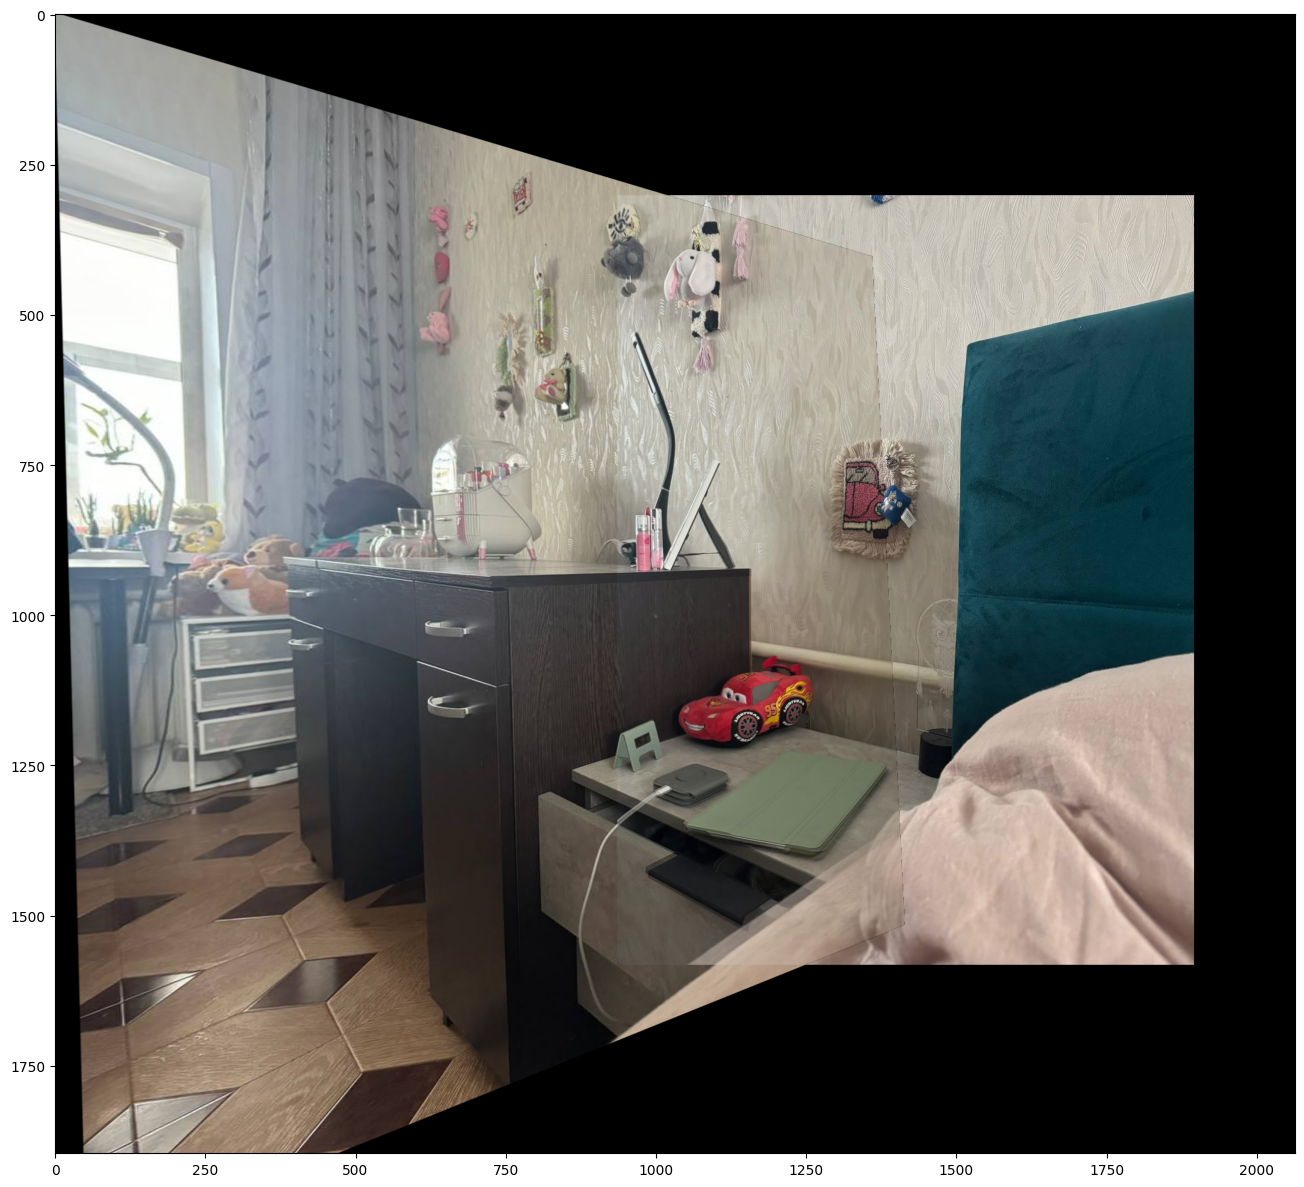

In [380]:
def build_resulting_image(box, hmat_results):
    results = []
    shape = np.array([
        box[1,0] - box[0, 0], # h
        box[1,1] - box[0, 1]  # w
    ])
    offset = np.array([
        [1, 0, -box[0, 1]], # -x_min
        [0, 1, -box[0, 0]], # -y_min
        [0, 0, 1],
    ]).astype(np.float32)
    for mat, image in hmat_results:
        results.append(
            # Why offset is first term?
            # Source image origin will be mapped to origin of resulting image, but we need to translate it by -x_min,
            # And what's crucial we must do this wrt to perspective
            # offset @ mat is right multiplied, ie image @ (offset @ mat) - so at first we offset image and then apply homography
            cv2.warpPerspective(image, offset @ mat, dsize=shape)
        )
    res = np.array(results)
    denominator = (res[:, ] != 0).sum(axis=0) # hacky way to calculate mean, excluding black pixels
    return (res.sum(axis=0) / denominator).astype(np.uint8)

panorama = build_resulting_image(resulting_frame, hmats)
plt.figure(figsize=(16, 16))
plt.imshow(panorama)